In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pickle

In [3]:
raw_data = pd.read_csv('all_seasons_avg_stats.csv',index_col=0)
current_season_filter = raw_data['SEASON_YEAR']=='2020-21'
data = raw_data[current_season_filter]
features = data.iloc[:,2:]
print(len(features.columns))

27


In [4]:
features.head(3)

,OFF_RATING,DEF_RATING,AST_PCT,AST_TOV,AST_RATIO,OREB_PCT,DREB_PCT,REB_PCT,USG_PCT,POSS,...,FGA_P100,FTM_P100,FTA_P100,FG3M_P100,FG3A_P100,SSN_FG_PCT,SSN_FT_PCT,SSN_FG3_PCT,SSN_EFG_PCT,SSN_TS_PCT
9399,112.862000,110.964000,0.158140,1.306600,17.896000,0.053100,0.152380,0.102400,0.201560,57.360000,...,17.398884,3.382148,5.195258,2.057183,6.136681,0.462926,0.651007,0.335227,0.522044,0.547329
9400,107.525758,113.340909,0.122636,1.034848,15.922727,0.011742,0.057530,0.034333,0.190288,38.787879,...,17.031250,2.656250,3.242188,2.617188,7.109375,0.389908,0.819277,0.368132,0.466743,0.502624
9401,104.521739,107.193478,0.047130,0.217391,9.610870,0.031587,0.141804,0.085130,0.147217,30.630435,...,12.633073,1.561391,1.987225,2.838893,7.665011,0.438202,0.785714,0.370370,0.550562,0.572720


Let's try some initial clusterings and try to find the optimal clusters through a combination of evaluating metrics and domain knowledge. A couple of the metrics we will use to evaluate are sum of squared error (SSE) and the silhouette score. 

- SSE 
- Silhouette score

How close the data point is to other points in the cluster
How far away the data point is from points in other clusters

In [5]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [6]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [7]:
# # Save scaler
# with open("scaler2.pkl", "wb") as f:
#     pickle.dump(scaler, f)

In [8]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

C:\Users\arthu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


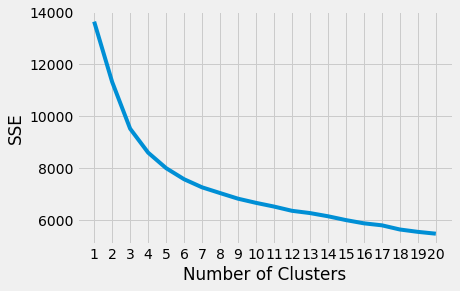

In [9]:
%matplotlib inline

plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), sse)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [10]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

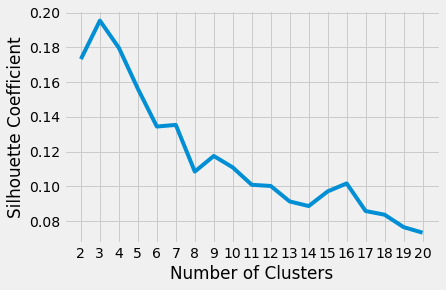

In [11]:
%matplotlib inline

plt.style.use("fivethirtyeight")
plt.plot(range(2, 21), silhouette_coefficients)
plt.xticks(range(2, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

SSE - 4,9

Silhouette - 4,7,12,17

Let's create a function for easily viewing players in k clusters and visualizing labels in 3 dimensions. 

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
principalComponents = pca.fit_transform(scaled_features)
print("Variance Explained by first 15 principal components:", sum(pca.explained_variance_ratio_))
pca_reduced_data = pd.concat([data.reset_index().iloc[:,2],pd.DataFrame(principalComponents)],axis=1)

Variance Explained by first 15 principal components: 0.9861598882299811


In [13]:
# Save PCA
# with open("pca2.pkl", "wb") as f:
#     pickle.dump(pca, f)

In [14]:
for pc_num in [0,1,2,3]:
    print("")
    print("top 7 features in principal components {number}: ".format(number=pc_num))
    print(pd.DataFrame(zip(data.columns[1:].to_list(), pca.components_[pc_num])).sort_values(by=1,ascending=False).head(7))


top 7 features in principal components 0: 
             0         1
15    BLK_P100  0.334984
16    PTS_P100  0.312545
8      REB_PCT  0.301794
17    FGM_P100  0.294184
3      AST_PCT  0.280105
9      USG_PCT  0.274867
2   DEF_RATING  0.240436

top 7 features in principal components 1: 
            0         1
11        PIE  0.372347
7    DREB_PCT  0.369154
5   AST_RATIO  0.355577
6    OREB_PCT  0.315376
22  FG3A_P100  0.271860
14   STL_P100  0.266030
19   FTM_P100  0.175114

top 7 features in principal components 2: 
             0         1
2   DEF_RATING  0.309847
12    REB_P100  0.293745
4      AST_TOV  0.236106
19    FTM_P100  0.211759
3      AST_PCT  0.172409
18    FGA_P100  0.169961
8      REB_PCT  0.126100

top 7 features in principal components 3: 
              0         1
4       AST_TOV  0.443300
12     REB_P100  0.264285
13     AST_P100  0.246712
3       AST_PCT  0.243907
22    FG3A_P100  0.235080
25  SSN_FG3_PCT  0.220962
2    DEF_RATING  0.191909


In [16]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42,}

sse_pca = []
silhouette_coefficients_pca = []

for k in range(2, 31):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(principalComponents)
    
#     Save model
    with open("kmeans_k_{clusters}.pkl".format(clusters=k), "wb") as f:
        pickle.dump(kmeans, f)
        
    sse_pca.append(kmeans.inertia_)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients_pca.append(score)

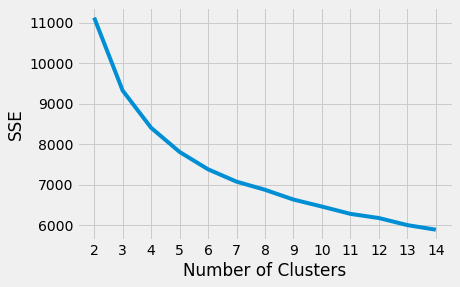

In [123]:
%matplotlib inline

plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), sse_pca)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

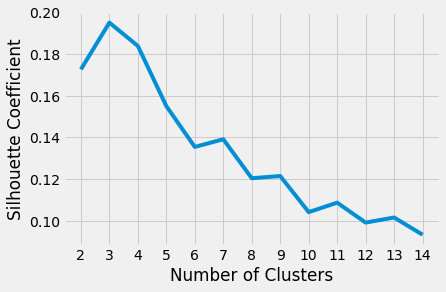

In [124]:
%matplotlib inline

plt.style.use("fivethirtyeight")
plt.plot(range(2, 15), silhouette_coefficients_pca)
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [150]:
kmeans_kwargs = {"init": "random","n_init": 10,"max_iter": 300,"random_state": 42}

def display_players_for_k_clusters(k=k,features=features):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    
    # Save model
#     with open("kmeans2.pkl", "wb") as f:
#         pickle.dump(kmeans, f)
    
    data_temp = data.copy()
    data_temp['labels'] = kmeans.labels_
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection='3d')
    ax.legend(kmeans.labels_)
    ax.set_xlabel('PCA Component 0')
    ax.set_ylabel('PCA Component 1')
    ax.set_zlabel('PCA Component 2')
    
    for lbl in np.unique(kmeans.labels_):
        indices = np.where(kmeans.labels_ == lbl)
        x = pca_reduced_data[0].loc[indices]
        y = pca_reduced_data[1].loc[indices]
        z = pca_reduced_data[2].loc[indices]
        ax.scatter(x, y, z, label=str(lbl), cmap='rainbow')
    
    ax.legend()
#     plt.show()
    
    print("# of Total Players: ",len(data_temp))
    
    with pd.option_context('display.max_columns', None): 
        print(data_temp.groupby(by='labels').mean())

    for cluster in np.sort(data_temp['labels'].unique()):
        print("CLUSTER: ",cluster)
        print("NUMBER OF PLAYERS: ",len(data_temp[data_temp['labels']==cluster]))
        with pd.option_context('display.max_columns', None): 
            print("AVERAGE STATS: ")
            print(data_temp[data_temp['labels']==cluster].mean().to_frame().T)
        print("EXAMPLE PLAYERS: ")
        print(data_temp[data_temp['labels']==cluster].iloc[:,1].sample(10,replace=False))

<IPython.core.display.Javascript object>


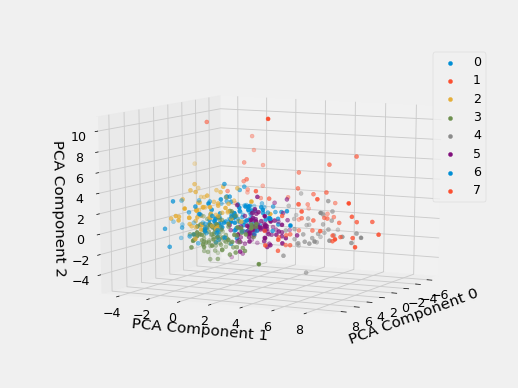

# of Total Players:  505
        OFF_RATING  DEF_RATING   AST_PCT   AST_TOV  AST_RATIO  OREB_PCT  \
labels                                                                    
0       113.979545  111.376286  0.266811  2.284651  19.621225  0.031719   
1        93.204026   99.067108  0.104447  0.283638  11.307399  0.036645   
2       109.082101  109.462167  0.255357  2.072902  28.050091  0.021559   
3       108.659263  110.396936  0.111291  0.830196  13.042671  0.021952   
4       104.407798  108.638144  0.078742  0.457414  13.088808  0.085297   
5       105.486242  109.979734  0.098975  0.656725  14.986991  0.040802   
6        97.334686  108.571661  0.101600  0.408327  14.893673  0.024999   
7       107.136269  110.203051  0.091640  0.544580  10.106440  0.099753   

        DREB_PCT   REB_PCT   USG_PCT       POSS  ...   FGA_P100  FTM_P100  \
labels                                           ...                        
0       0.152565  0.092876  0.286914  71.247110  ...  24.846607  6.564

In [147]:
%matplotlib notebook

display_players_for_k_clusters(k=8,features=scaled_features)

Some interesting clusters (we can see guards, non shooting bigs, etc.), but very volume based.

<IPython.core.display.Javascript object>


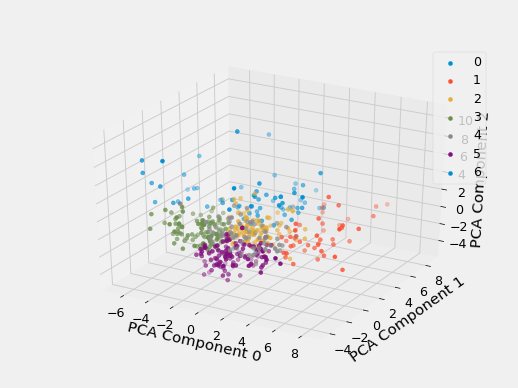

# of Total Players:  505
        OFF_RATING  DEF_RATING   AST_PCT   AST_TOV  AST_RATIO  OREB_PCT  \
labels                                                                    
0        91.547620   99.085555  0.124488  0.307128  12.466065  0.049385   
1       113.979545  111.376286  0.266811  2.284651  19.621225  0.031719   
2       105.310454  110.419126  0.098206  0.643058  12.498811  0.053652   
3        98.516128  107.954805  0.092604  0.411695  14.530804  0.028663   
4       108.620328  109.332957  0.254171  2.048569  28.100602  0.020120   
5       107.819061  110.644404  0.109469  0.780830  13.711677  0.020533   
6       108.413217  108.973135  0.087121  0.552377  13.163621  0.103780   

        DREB_PCT   REB_PCT   USG_PCT       POSS       PIE   REB_P100  \
labels                                                                 
0       0.184712  0.112654  0.171491  17.912965  0.024122  12.104875   
1       0.152565  0.092876  0.286914  71.247110  0.146189   8.961055   
2       0.1

In [151]:
%matplotlib notebook

display_players_for_k_clusters(k=7,features=pca_reduced_data.iloc[:,1:])